In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle

def custom_manhattan_plot(df, chr_col='Chr', pv_col='Pvalue', point_col='Gene', 
                         highlighted_points=None, point_colors=None, 
                         base_colors=("#ef8a62", "#67a9cf"), 
                         gwas_threshold=5e-8, suggestive_threshold=None,
                         figsize=(15, 6), dotsize=2, alpha=0.7, 
                         title="Manhattan Plot", save_path=None,
                         show_labels=True, label_fontsize=8, label_offset=(5, 5),
                         avoid_label_overlap=True, axxlabel='Chromosome', axylabel=r'$ -log_{10}(P)$',
                         axxlabelsize=12, axylabelsize=12, title_fontsize=14, 
                         highlited_points_factor_dotsize=3, format='pdf', show_plot=True, show_legend=True):
    """
    Create a custom Manhattan plot with gene-specific colors
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data
    chr_col : str
        Column name for chromosome
    pv_col : str  
        Column name for p-values
    point_col : str
        Column name for gene names
    highlighted_points : list
        List of gene names to highlight
    point_colors : dict or list
        Colors for highlighted genes. Can be dict {gene: color} or list of colors
    base_colors : tuple
        Base colors for alternating chromosomes
    gwas_threshold : float
        GWAS significance threshold (default: 5e-8)
    suggestive_threshold : float
        Suggestive significance threshold (default: 1e-5)
    figsize : tuple
        Figure size (width, height)
    dotsize : int
        Size of dots
    alpha : float
        Transparency of dots
    title : str
        Plot title
    save_path : str
        Path to save the plot (optional)
    show_labels : bool
        Whether to show gene labels (default: True)
    label_fontsize : int
        Font size for gene labels (default: 8)
    label_offset : tuple
        Offset for labels in points (x, y) (default: (5, 5))
    avoid_label_overlap : bool
        Whether to try to avoid label overlap (default: True)
    axxlabel : str
        Label for x-axis (default: 'Chromosome')
    axylabel : str
        Label for y-axis (default: '-log₁₀(P-value)')
    axxlabelsize : int
        Font size for x-axis label (default: 12)
    axylabelsize : int
        Font size for y-axis label (default: 12)
    title_fontsize : int
        Font size for plot title (default: 14)
    highlited_points_factor_dotsize : int
        Factor to increase dot size for highlighted points (default: 3)
    format : str
        Format to save the plot (default: 'pdf')
    show_plot : bool
        Whether to display the plot (default: True)
    show_legend : bool
        Whether to show the legend for highlighted genes (default: True)
    """
    
    # Create a copy of the dataframe to avoid modifying the original
    plot_df = df.copy()
    
    # Convert p-values to -log10
    plot_df['-log10_pv'] = -np.log10(plot_df[pv_col])
    
    # Get unique chromosomes and sort them
    chromosomes = sorted(plot_df[chr_col].unique())
    
    # Create chromosome positions for x-axis
    plot_df['pos'] = 0
    cumulative_pos = 0
    chr_centers = {}
    chr_boundaries = []
    
    for i, chrom in enumerate(chromosomes):
        chr_data = plot_df[plot_df[chr_col] == chrom]
        chr_length = len(chr_data)
        
        # Assign positions
        plot_df.loc[plot_df[chr_col] == chrom, 'pos'] = np.arange(cumulative_pos, cumulative_pos + chr_length)
        
        # Store chromosome center for labeling
        chr_centers[chrom] = cumulative_pos + chr_length / 2
        
        # Store boundaries for alternating colors
        if i > 0:
            chr_boundaries.append(cumulative_pos)
        
        cumulative_pos += chr_length
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot points with alternating chromosome colors
    for i, chrom in enumerate(chromosomes):
        chr_data = plot_df[plot_df[chr_col] == chrom]
        color = base_colors[i % 2]
        
        ax.scatter(chr_data['pos'], chr_data['-log10_pv'], 
                  c=color, s=dotsize, alpha=alpha, edgecolors='none')
    
    # Highlight specific genes if provided
    if highlighted_points is not None:
        highlighted_data = plot_df[plot_df[point_col].isin(highlighted_points)]
        
        # Sort by p-value for better label placement
        highlighted_data = highlighted_data.sort_values('-log10_pv', ascending=False)
        
        if point_colors is None:
            # Use default highlight color
            highlight_color = 'red'
            ax.scatter(highlighted_data['pos'], highlighted_data['-log10_pv'], 
                      c=highlight_color, s=dotsize*highlited_points_factor_dotsize, alpha=1.0, edgecolors='black', linewidth=0.5)
            
        else:
            # Use custom colors for each gene
            if isinstance(point_colors, dict):
                for gene in highlighted_points:
                    gene_data = highlighted_data[highlighted_data[point_col] == gene]
                    if len(gene_data) > 0:
                        color = point_colors.get(gene, 'red')
                        ax.scatter(gene_data['pos'], gene_data['-log10_pv'], 
                                  c=color, s=dotsize*highlited_points_factor_dotsize, alpha=1.0, edgecolors='black', linewidth=0.5,
                                  label=gene)
                        
            elif isinstance(point_colors, (list, tuple)):
                for i, gene in enumerate(highlighted_points):
                    gene_data = highlighted_data[highlighted_data[point_col] == gene]
                    if len(gene_data) > 0:
                        color = point_colors[i % len(point_colors)]
                        ax.scatter(gene_data['pos'], gene_data['-log10_pv'], 
                                  c=color, s=dotsize*highlited_points_factor_dotsize, alpha=1.0, edgecolors='black', linewidth=0.5,
                                  label=gene)
            
        # Add labels for all highlighted genes
        if show_labels:
            label_positions = []
    
            for _, row in highlighted_data.iterrows():
                x, y = row['pos'], row['-log10_pv']
                
                if avoid_label_overlap:
                    # Simple overlap avoidance: adjust y position if too close to existing labels
                    adjusted_y = y
                    for prev_x, prev_y in label_positions:
                        if abs(x - prev_x) < 50:  # If x positions are close
                            if abs(adjusted_y - prev_y) < 0.5:  # If y positions are close
                                adjusted_y = prev_y + 0.7  # Offset upward
                    
                    label_positions.append((x, adjusted_y))
                    
                    # Draw a line from the actual point to the label if offset
                    if adjusted_y != y:
                        ax.plot([x, x], [y, adjusted_y], 'k-', alpha=0.3, linewidth=0.5)
                    
                    ax.annotate(row[point_col], 
                            (x, adjusted_y),
                            xytext=label_offset, textcoords='offset points',
                            fontsize=label_fontsize, ha='left', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.6)
                            if adjusted_y != y else None)
                else:
                    # Simple labeling without overlap avoidance
                    ax.annotate(row[point_col], 
                            (x, y),
                            xytext=label_offset, textcoords='offset points',
                            fontsize=label_fontsize, ha='left', va='bottom',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=0.6))

    # Add significance lines
    if gwas_threshold:
        gwas_line = -np.log10(gwas_threshold)
        ax.axhline(y=gwas_line, color='red', linestyle='--', alpha=0.7, 
                  label=f'GWAS threshold (p={gwas_threshold:.0e})')
    
    if suggestive_threshold:
        suggestive_line = -np.log10(suggestive_threshold)
        ax.axhline(y=suggestive_line, color='blue', linestyle='--', alpha=0.7,
                  label=f'Suggestive threshold (p={suggestive_threshold:.0e})')
    
    # Customize the plot
    ax.set_xlabel(axxlabel, fontsize=axxlabelsize)
    ax.set_ylabel(axylabel, fontsize=axylabelsize)
    ax.set_title(title, fontsize=title_fontsize, fontweight='bold')
    
    # Set x-axis ticks and labels
    ax.set_xticks(list(chr_centers.values()))
    ax.set_xticklabels(chromosomes)
    
    # Add vertical lines between chromosomes
    for boundary in chr_boundaries:
        ax.axvline(x=boundary, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0, right=cumulative_pos)
    
    # Add grid
    # ax.grid(True, alpha=0.3)
    
    # Add legend if genes are highlighted
    if highlighted_points is not None and point_colors is not None and show_legend:
        ax.legend(bbox_to_anchor=(1, 1.015), loc='upper left')
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save plot if path is provided
    if save_path:
        print(f"Saving plot to {save_path}...")
        plt.savefig(save_path, dpi=300, bbox_inches='tight', format=format)
    
    if show_plot:
        plt.show()

    

Saving plot to ../results/psoriasis/magma/magma_output_50kb_window_snp-array/figures/manhattan_plot_magma_pvalues.pdf...


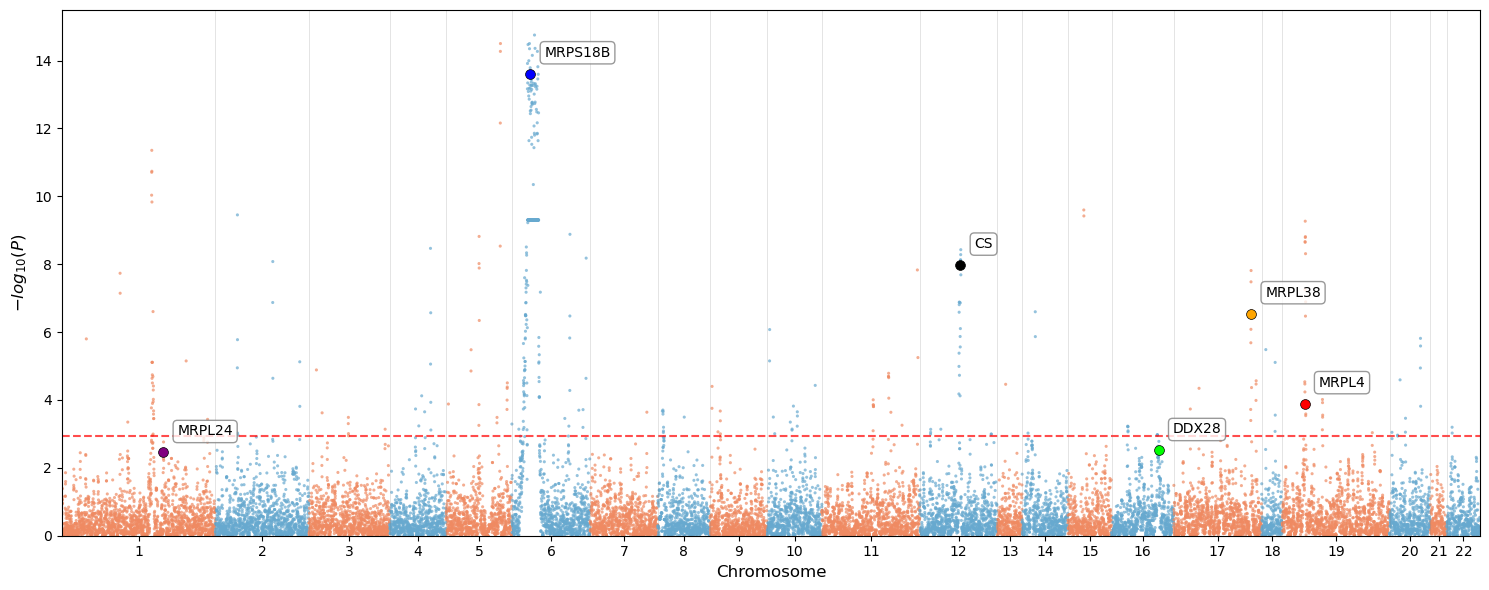

In [62]:
import pandas as pd
df = pd.read_csv('../results/psoriasis/magma/magma_output_50kb_window_snp-array/pso.scores.genes.out_converted.tsv', sep="\t")

point_colors = {
    "MRPL4": "#FF0000",    # Red
    "DDX28": "#00FF00",    # Green  
    "MRPS18B": "#0000FF",  # Blue
    "MRPL38": "#FFA500",   # Orange
    "MRPL24": "#800080",   # Purple
    "CS": "#000000"        # Black
}

# Create the plot
custom_manhattan_plot(
    df=df,
    chr_col='Chr',
    pv_col='Pvalue',
    point_col='Gene',
    highlighted_points=["MRPL4", "DDX28", "MRPS18B", "MRPL38", "MRPL24", "CS"],
    point_colors=point_colors,
    gwas_threshold=0.00119237,
    show_labels=True,
    label_fontsize=10,           # Larger font
    label_offset=(10, 10),       # More offset from points
    avoid_label_overlap=True,     # Smart positioning
    highlited_points_factor_dotsize=10,
    dotsize=5,
    title="",
    show_legend=False,
    save_path='../results/psoriasis/magma/magma_output_50kb_window_snp-array/figures/manhattan_plot_magma_pvalues.pdf',
)